<a href="https://colab.research.google.com/github/kaueag/Projetos-pessoais/blob/main/Projeto%20de%20clusteriza%C3%A7%C3%A3o%20com%20KMeans.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%capture
%pip install kmodes

In [ ]:
# Importações necessárias
import pandas as pd
import numpy as np


# Visualização de dados
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer, InterclusterDistance, kelbow_visualizer, silhouette_visualizer

## -- Machine learning -- ##
from sklearn import datasets
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans, DBSCAN, MeanShift
from sklearn.cluster import k_means, dbscan, mean_shift, estimate_bandwidth
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale, StandardScaler, MinMaxScaler

from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

from kmodes.kmodes import KModes            # clustering categorical data
from kmodes.kprototypes import KPrototypes  # clustering mixed data

# Didatic purposes
import string
from ipywidgets import interact

In [ ]:
#Importando os dados
from google.colab import drive
drive.mount('/content/drive')




Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/data_desafio7.csv', encoding='latin-1')

In [ ]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


## Data Cleaning

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [ ]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], format = '%m/%d/%Y %H:%M')

### Verificando duplicatas

In [ ]:
df.duplicated().any()

True

In [ ]:
df = df.drop_duplicates()

In [ ]:
df['Description'].nunique()

4223

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 536641 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    536641 non-null  object        
 1   StockCode    536641 non-null  object        
 2   Description  535187 non-null  object        
 3   Quantity     536641 non-null  int64         
 4   InvoiceDate  536641 non-null  datetime64[ns]
 5   UnitPrice    536641 non-null  float64       
 6   CustomerID   401604 non-null  float64       
 7   Country      536641 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 36.8+ MB


### Verificando linhas nulas

In [ ]:
df.isna().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135037
Country             0
dtype: int64

In [ ]:
df = df.dropna()

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 401604 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    401604 non-null  object        
 1   StockCode    401604 non-null  object        
 2   Description  401604 non-null  object        
 3   Quantity     401604 non-null  int64         
 4   InvoiceDate  401604 non-null  datetime64[ns]
 5   UnitPrice    401604 non-null  float64       
 6   CustomerID   401604 non-null  float64       
 7   Country      401604 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 27.6+ MB


In [ ]:
df['CustomerID'] = df['CustomerID'].astype(int)

<ipython-input-136-b57c4042606f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CustomerID'] = df['CustomerID'].astype(int)


### Verificando outliers

In [ ]:
df.sort_values(by="Quantity", ascending=False)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
540421,581483,23843,"PAPER CRAFT , LITTLE BIRDIE",80995,2011-12-09 09:15:00,2.08,16446,United Kingdom
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346,United Kingdom
502122,578841,84826,ASSTD DESIGN 3D PAPER STICKERS,12540,2011-11-25 15:57:00,0.00,13256,United Kingdom
421632,573008,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,4800,2011-10-27 12:26:00,0.21,12901,United Kingdom
206121,554868,22197,SMALL POPCORN HOLDER,4300,2011-05-27 10:52:00,0.72,13135,United Kingdom
...,...,...,...,...,...,...,...,...
160144,C550456,21175,GIN + TONIC DIET METAL SIGN,-2000,2011-04-18 13:08:00,1.85,15749,United Kingdom
160145,C550456,21108,FAIRY CAKE FLANNEL ASSORTED COLOUR,-3114,2011-04-18 13:08:00,2.10,15749,United Kingdom
4287,C536757,84347,ROTATING SILVER ANGELS T-LIGHT HLDR,-9360,2010-12-02 14:23:00,0.03,15838,United Kingdom
61624,C541433,23166,MEDIUM CERAMIC TOP STORAGE JAR,-74215,2011-01-18 10:17:00,1.04,12346,United Kingdom


<Axes: >

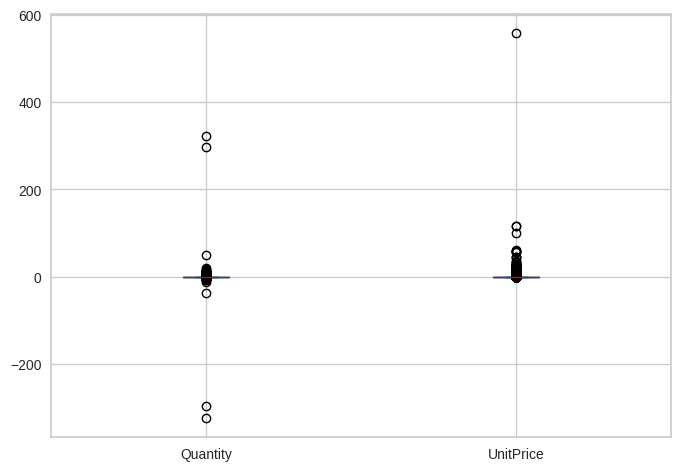

In [ ]:
# Selecionar apenas as colunas numéricas
colunas_numericas = df.drop('CustomerID', axis=1).select_dtypes(include=['number'])

# Aplicar a função de escala
colunas_scaled = colunas_numericas.apply(scale)

# Plotar o boxplot
colunas_scaled.plot.box()

In [ ]:
colunas_numericas.describe(percentiles=[0.25, .5, .75, .9, .99])

,Quantity,UnitPrice
count,401604.000000,401604.000000
mean,12.183273,3.474064
std,250.283037,69.764035
min,-80995.000000,0.000000
25%,2.000000,1.250000
50%,5.000000,1.950000
75%,12.000000,3.750000
90%,24.000000,6.750000
99%,120.000000,15.000000
max,80995.000000,38970.000000


### Limpando Outliers

In [ ]:
df_sem_outliers = df.query("Quantity>0 & Quantity <= 120")

In [ ]:
df_sem_outliers = df_sem_outliers.query("UnitPrice < 20")

<Axes: >

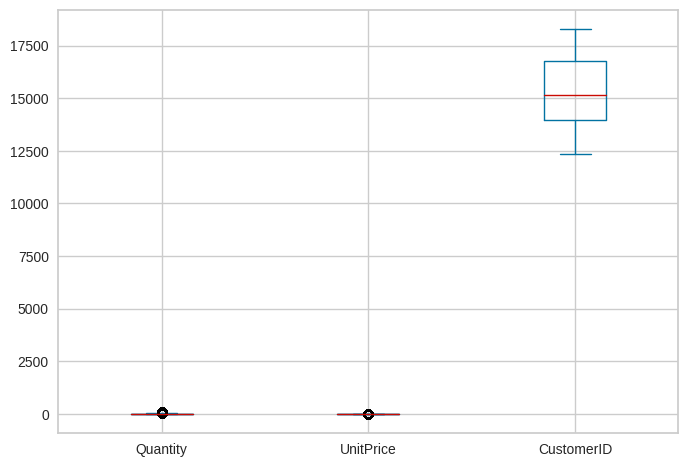

In [ ]:
# Retirei os valores de quantidades negativos, já que não faz sentido e também retirei os valores tanto de quantidade quanto de preço que estavam abaixo do quantil de 99%

df_sem_outliers.plot.box()

In [ ]:
num_cols = ['Quantity', 'UnitPrice', 'InvoiceDate']
cat_cols = ['InvoiceNo', 'StockCode', 'Description', 'CustomerID', 'Country']

In [ ]:
df_sem_outliers.describe()

,Quantity,InvoiceDate,UnitPrice,CustomerID
count,387715.000000,387715,387715.000000,387715.000000
mean,9.955349,2011-07-10 21:35:37.395406848,2.827238,15289.310408
min,1.000000,2010-12-01 08:26:00,0.000000,12347.000000
25%,2.000000,2011-04-07 11:16:00,1.250000,13959.000000
50%,6.000000,2011-07-31 12:47:00,1.950000,15152.000000
75%,12.000000,2011-10-20 13:24:00,3.750000,16791.000000
max,120.000000,2011-12-09 12:50:00,19.960000,18287.000000
std,14.610540,NaN,2.796098,1712.045637


## Cálculo de preço total e data mais recente

In [ ]:
#Adicionando a coluna de Preço Total e data final de compra para fazer o cálculo de recência

df_sem_outliers['TotalPrice'] = df['Quantity'] * df['UnitPrice']
data_final = df_sem_outliers['InvoiceDate'].max()

#Análises com dados categóricos

In [ ]:
#Top 10 países com maior valor em vendas (TotalPrice, que é a quantidade * unitprice)
top_countries = df_sem_outliers.groupby('Country')['TotalPrice'].sum().sort_values(ascending=False)
top10_countries = top_countries.head(10)

display(top10_countries)


#Calculando a soma total dos preços por país e selecionando os 10 primeiros países
top10list_soma_total = df_sem_outliers.groupby('Country')['TotalPrice'].sum().sort_values(ascending=False).head(10).index.tolist()

Country
United Kingdom    5754872.884
Germany            219416.220
EIRE               201789.020
France             189685.930
Netherlands        165236.170
Australia           79163.170
Switzerland         52132.390
Spain               44446.140
Belgium             40713.160
Norway              31526.280
Name: TotalPrice, dtype: float64

In [ ]:
#Top 10 produtos mais vendidos
top10_products = df_sem_outliers.groupby('StockCode').sum('TotalPrice').sort_values('TotalPrice', ascending=False).head(10).reset_index()['StockCode'].to_list()

top10_products

['22423',
 '85123A',
 '47566',
 '85099B',
 'POST',
 '84879',
 '79321',
 '22086',
 '23298',
 '22960']

##Gráficos para análise

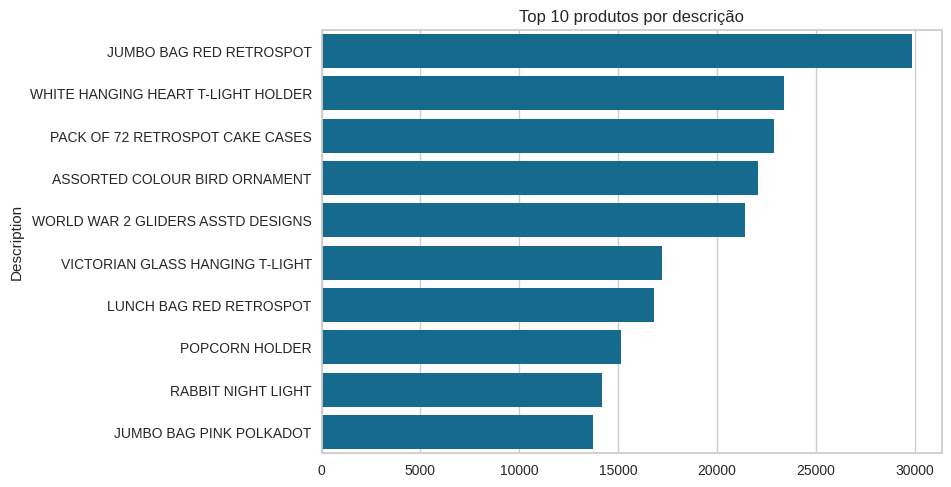

In [ ]:
# Os produtos mais vendidos pela descrição
top10_desc = df_sem_outliers.groupby('Description')['Quantity'].sum().sort_values(ascending=False).head(10)
sns.barplot(x = top10_desc.values, y=top10_desc.index)


plt.title('Top 10 produtos por descrição')
plt.show()

In [ ]:
#Filtrando o DataFrame para incluir apenas os países na lista top10list_soma_total
df_filtrado = df_sem_outliers[df_sem_outliers['Country'].isin(top10list_soma_total)]

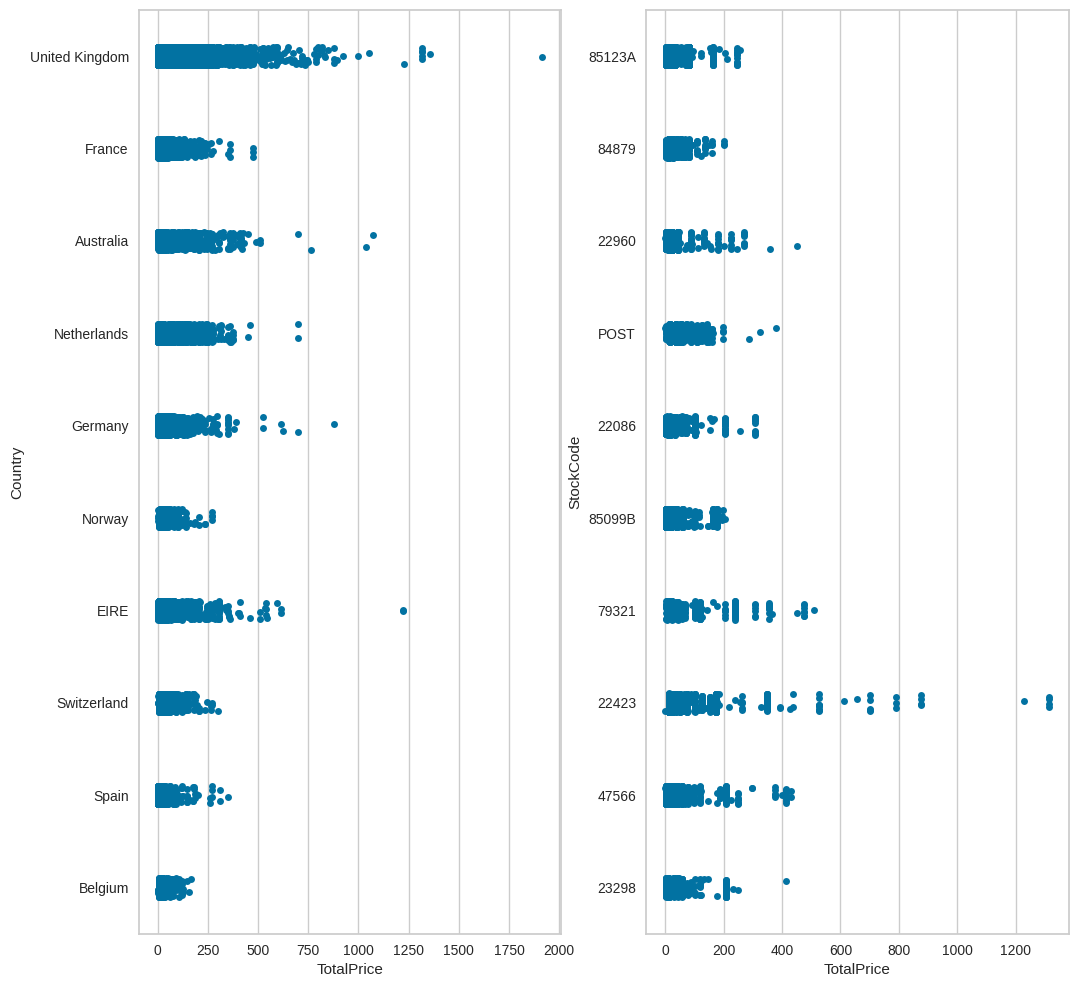

In [ ]:
#Gráfico com os países que mais vendem por total de preço e gráfico de código dos produtos mais vendidos no total


fig, axes = plt.subplots(1,2, figsize=(12,12))
sns.stripplot(data=df_filtrado, x='TotalPrice', y='Country', ax=axes[0])

sns.stripplot(data = df_sem_outliers.loc[df_sem_outliers['StockCode'].isin(top10_products)], x='TotalPrice', y='StockCode', ax=axes[1])

plt.show()

##Cálculo do RFV

In [ ]:
#Calculando a recência, ou seja, quantos dias desde a última compra:
rfv_recency = pd.DataFrame(df_sem_outliers.groupby('CustomerID').agg({'InvoiceDate': lambda x: (((data_final - x.max()).days) + 1)}))

#Calculando a frequência, ou seja, quantas vezes (quantos dias únicos) o mesmo Customer fez uma compra
rfv_frequency = pd.DataFrame(df_sem_outliers.groupby('CustomerID').agg({'InvoiceDate': 'nunique'}))

#Calculando o total gasto pelo mesmo usuário
rfv_value = pd.DataFrame(df_sem_outliers.groupby('CustomerID').agg({'TotalPrice': 'sum'}))

#Alterando o nome das colunas para melhor entendimento
rfv_recency.columns = ['Recencia']
rfv_frequency.columns = ['Frequencia']
rfv_value.columns = ['Valor_Total']

#Juntando tudo em um só dataframe
rfv = pd.concat([rfv_recency, rfv_frequency, rfv_value], axis=1)

rfv.head().sort_values(by='Frequencia', ascending=False)

,Recencia,Frequencia,Valor_Total
CustomerID,,,
12347,2,7,4060.40
12352,36,7,1385.74
12348,75,4,1186.68
12349,19,1,1417.60
12350,310,1,294.40


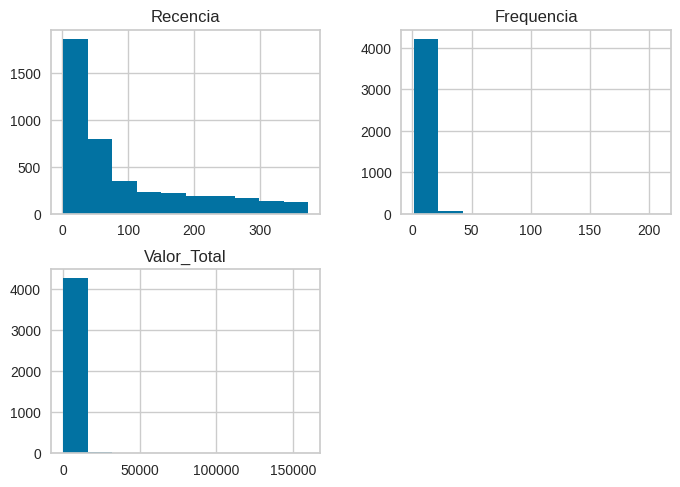

In [ ]:
#Verificando possível padrão de comportamento via histograma

rfv.hist()
plt.show()

In [ ]:
#Vamos usar o describe para tentar encontrar algum padrão de grupos, como por exemplo, frequência. O grupo que compra acima de 5 é minoritário, mas fiel. A maior parte das pessoas
rfv.describe().T


,count,mean,std,min,25%,50%,75%,max
Recencia,4293.0,92.624971,100.061472,1.0,18.0,51.00,143.00,374.0
Frequencia,4293.0,4.184253,7.451666,1.0,1.0,2.00,5.00,208.0
Valor_Total,4293.0,1627.306789,4866.700335,2.9,291.3,641.94,1561.61,160035.8


## Colocando o RFV em escala

In [ ]:
scaler = StandardScaler()
rfv_scaled = pd.DataFrame(scaler.fit_transform(rfv), columns=rfv.columns)

rfv_scaled.head()

,Recencia,Frequencia,Valor_Total
0,-0.905798,0.377912,0.500005
1,-0.176162,-0.024729,-0.090550
2,-0.735883,-0.427371,-0.043095
3,2.172668,-0.427371,-0.273915
4,-0.565968,0.377912,-0.049642


/usr/local/lib/python3.10/dist-packages/pandas/plotting/_matplotlib/core.py:1258: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  scatter = ax.scatter(


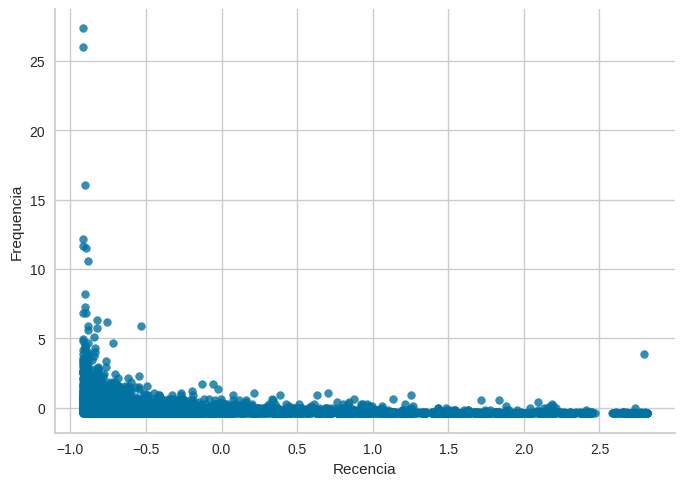

In [ ]:
#Recencia vs Frequencia

from matplotlib import pyplot as plt
rfv_scaled.plot(kind='scatter', x='Recencia', y='Frequencia', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
rfv_scaled.describe().T

,count,mean,std,min,25%,50%,75%,max
Recencia,4293.0,4.468822e-17,1.000116,-0.915793,-0.745878,-0.416042,0.503499,2.812349
Frequencia,4293.0,-3.310239e-18,1.000116,-0.427371,-0.427371,-0.293157,0.109484,27.354890
Valor_Total,4293.0,-6.620477e-18,1.000116,-0.333819,-0.274552,-0.202495,-0.013501,32.553257


# Clusterização


In [ ]:
#Escolhi usar o KMeans por usar somente os dados numéricos do RFV e por ser menos custosa computacionalmente.

model = KMeans()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

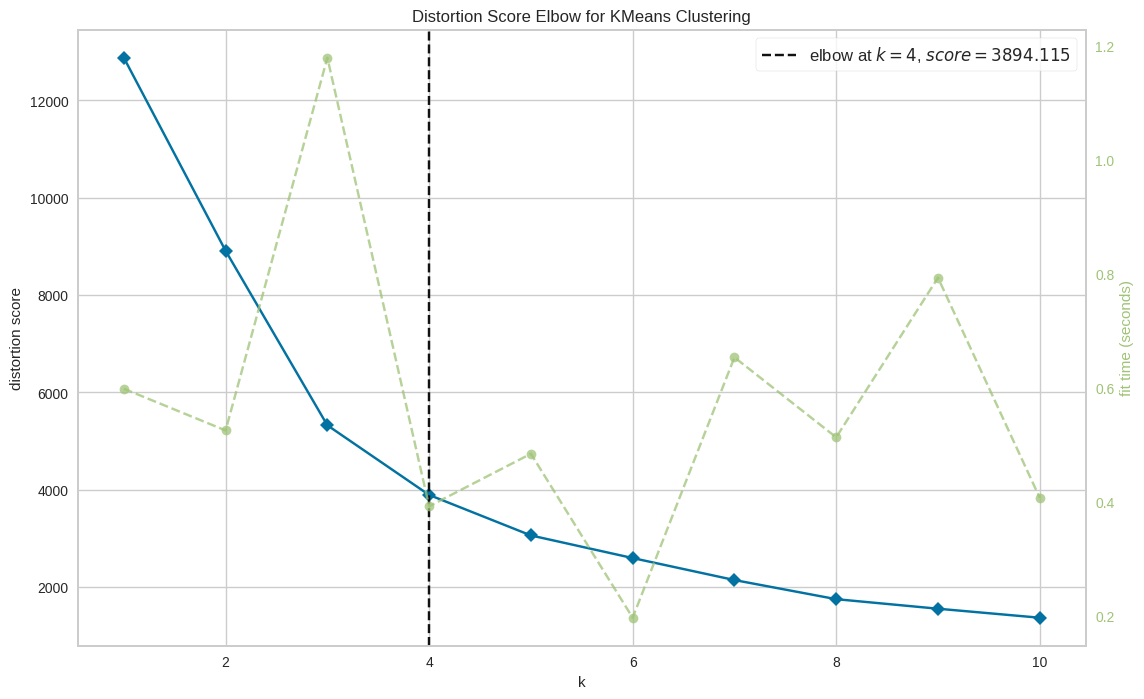

In [ ]:
plt.figure(figsize=(13,8));

kelbow_visualizer(model, rfv_scaled, k=(1,11));

plt.show();

In [ ]:
#Modelo com 4 clusters diferentes

model = KMeans(4, random_state = 0).fit(rfv_scaled)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [ ]:
centroids = model.cluster_centers_
labels = model.labels_

array([<Axes: title={'center': 'Groupo_0'}>,
       <Axes: title={'center': 'Groupo_1'}>,
       <Axes: title={'center': 'Groupo_2'}>,
       <Axes: title={'center': 'Groupo_3'}>], dtype=object)

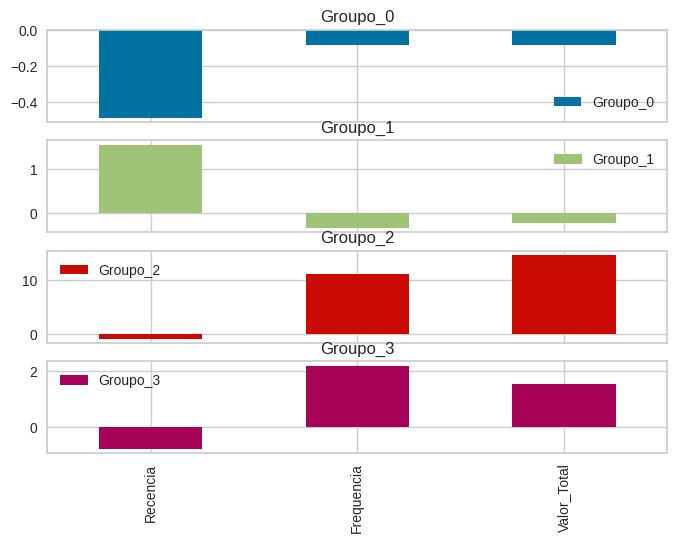

In [ ]:
pd.DataFrame(centroids, columns=rfv.columns).T.add_prefix('Groupo_').plot.bar(subplots=True)

#Conclusão

Podemos observar que temos 4 grupos distintos a partir da clusterização do RFV.

- O Grupo 0 é um grupo de clientes basicamente perdidos, faz tempo que não compram nada, gastaram pouco e a frequência baixa também. Podemos focar em alguma campanha de branding ou descobrir por qual motivo abandonaram nosso serviço para podermos ativar novamente esse grupo.
- Grupo 1 é um grupo mais quente, acabou de comprar, mas não é tão frequente e também não gasta muito. É um grupo que vale a pena investir em follow-up, promoções, envio de e-mails com produtos semelhantes que ele comprou em promoção.
- Grupo 2 é o grupo mais fiel, que vale a pena fazer algum tipo de relacionamento, que compra com grande frequência e gasta bastante e tem uma recência ok. É um grupo que não podemos perder, já que é o grupo que mais traz lucro para a empresa.
- Grupo 3 é outro grupo importante, gasta menos que o grupo 2 e tem menor frequência, mas é um grupo que importante também pois são clientes fedelizáveis em potencial.